# Introduction:
This is a multilabel classification example. The aim of this machine learning project is predict acceptability of car..

# What Is Machine Learning Pipeline?

Machine learning pipeline is used to help automate machine learning workflows. They operate by enabling a sequence of data to be transformed and correlated together in a model that can be tested and evaluated to achieve an outcome.

# Algorithm:

SVM and Random Forest.

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

k_fold = model_selection.KFold(n_splits=5, random_state=123)
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from joblib import dump, load

# 1. Data Preparation
## 1.1 Import Car Evaluation Dataset

In [2]:
df = pd.read_csv(r'C:\Users\user\Desktop\Data_Science\Car\car_evaluation.csv')  
# show first 3 rows
df.head(3)

,buying_price,maintenance_cost,number_of_doors,number_of_persons,lug_boot,safety,decision
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc


In [6]:
report = pandas_profiling.ProfileReport(df)
from IPython.core.display import display, HTML;display(HTML(report))

TypeError: 'ProfileReport' object is not subscriptable

## 1.2 Data Exploration

### 1.2.1. Target Variable (Y) --- decision

In this dataset, "decision" variable refer to car acceptability.

Note that it is an imbalanced dataset. Imbalance means that the number of data points available for different the classes is different.

For imbalanced dataset, we need to pay attention to classification performance method.

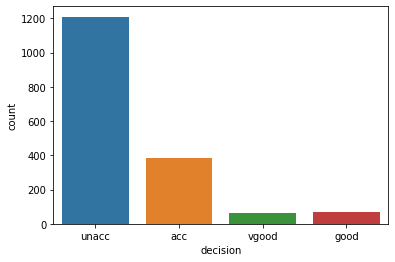

In [55]:
Y = df['decision']
ax = sns.countplot(Y)

### 1.2.2. Numeric Feature & Categorical Feature (X)

In [56]:
X = df.drop('decision', axis=1)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print("There are",X.shape[0], "rows and" , X.shape[1] , "feature(s) in dataset.")
print("-----------------------------------------------------------------------")

print("Number of numeric feature(s):",numeric_features.shape[0])
print("Variable(s) name:",numeric_features)
print("-----------------------------------------------------------------------")

print("Number of categorical feature(s):",categorical_features.shape[0])
print("Variable(s) name:",categorical_features)

There are 1728 rows and 6 feature(s) in dataset.
-----------------------------------------------------------------------
Number of numeric feature(s): 0
Variable(s) name: Index([], dtype='object')
-----------------------------------------------------------------------
Number of categorical feature(s): 6
Variable(s) name: Index(['buying_price', 'maintenance_cost', 'number_of_doors',
       'number_of_persons', 'lug_boot', 'safety'],
      dtype='object')


In [57]:
if numeric_features.shape[0] > 0:
    print(df[numeric_features].describe())
else:
    print("There is no numeric feature, skip this part")

There is no numeric feature, skip this part


In [58]:
if categorical_features.shape[0] > 0:
    print(df[categorical_features].describe())
else:
    print("There is no categorical feature, skip this part")

       buying_price maintenance_cost number_of_doors number_of_persons  \
count          1728             1728            1728              1728   
unique            4                4               4                 3   
top             low              low               2                 2   
freq            432              432             432               576   

       lug_boot safety  
count      1728   1728  
unique        3      3  
top       small    low  
freq        576    576  


# 2. Preprocessing of Machine Learning

## 2.1. Handling Missing Value

if there are missing values, impute missing values before building an estimator. For numeric feature and categorical feature, impute missing value with median and "missing" respectively. In this dataset, there are no missing values. 

In [59]:
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))
nulls.columns = ['Missing Value Count']
nulls.index.name = 'Feature'
print(nulls)

                   Missing Value Count
Feature                               
decision                             0
safety                               0
lug_boot                             0
number_of_persons                    0
number_of_doors                      0
maintenance_cost                     0
buying_price                         0


## 2.2.  Standardization of Numeric Feature

Standardize features by removing the mean and scaling to unit variance.

## 2.3. OneHot Encoding of Categorical Feature

One-hot encoding can be applied to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.

In [60]:
# Define funcation to store encoded column name
def get_feature_names(columnTransformer):

    output_features = []

    for name, pipe, features in columnTransformer.transformers_:
        if name!='remainder':
            for i in pipe:
                trans_features = []
                if hasattr(i,'categories_'):
                    trans_features.extend(i.get_feature_names(features))
                else:
                    trans_features = features
            output_features.extend(trans_features)

    return output_features

In [61]:
# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')

In [83]:
preprocessor.fit(X)
encoded_feature_names = get_feature_names(preprocessor)
print(encoded_feature_names)

['buying_price_high', 'buying_price_low', 'buying_price_med', 'buying_price_vhigh', 'maintenance_cost_high', 'maintenance_cost_low', 'maintenance_cost_med', 'maintenance_cost_vhigh', 'number_of_doors_2', 'number_of_doors_3', 'number_of_doors_4', 'number_of_doors_5more', 'number_of_persons_2', 'number_of_persons_4', 'number_of_persons_more', 'lug_boot_big', 'lug_boot_med', 'lug_boot_small', 'safety_high', 'safety_low', 'safety_med']


# 3. Classification Model Setting

The following setting will be applied in each classification model.

## 3.1. Model Validation

To aviod overfitting or underfitting problem, 5-folds cross-validation has applied.

The data set is split into 5 folds. In the first iteration, the first fold is used to test the model and the rest are used to train the model. This process is repeated until each fold of the 5 folds have been used as the testing set.

In [63]:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

k_fold = model_selection.KFold(n_splits=5, random_state=123)

## 3.2. Model Optimization

Turning model parameters with grid search.

## 3.3. Model Evaluation

The model selection criteria is balanced F-score in testing data.

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. 

Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). It can solve imbanlance dataset problem.

## 3.4. Speed up Training Time

Multiprocessing module to parallelize execution onto several Python processes by passing n_jobs = -2 as argument.

n_jobs = -2, all CPUs but one are used.

## 4. Support Vector Machine (SVM)

SVM find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.

There are 4 common kernel function, include linear, polynomial, rbf and sigmoid. 

In general, the RBF kernel is a reasonable first choice. This kernel nonlinearly maps samples into a higher dimensional space so it, unlike the linear kernel, can handle the
case when the relation between class labels and attributes is nonlinear.

https://scikit-learn.org/stable/modules/svm.html#svm-kernels

## 4.1  Turning Model Parameters with Grid Search

In SVM model, there are 2 parameters.

Cost: which controls training errors and margins. Small cost creates a large margin (a soft margin) and allows more misclassifications, and vice versa.

Gamma: how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’.

In [64]:
Cost = [2**i for i in range(-5,15)]
Gamma = [2**i for i in range(-15,3)]

print("Cost:",Cost)
print("Gamma:",Gamma)

Cost: [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
Gamma: [3.0517578125e-05, 6.103515625e-05, 0.0001220703125, 0.000244140625, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4]


if model exist, reload model. Otherwise, create new model and save it.

In [65]:
# Check if object exist
try:
    load('SVM_pipeline.joblib') 
except FileNotFoundError:
    print("The model is not exist, now create & save model")
    
    from sklearn import svm
    
    svm_grid = {'classifier__C': Cost, 'classifier__gamma': Gamma}
    
    SVM_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(kernel='rbf'))])
    
    svm_model = GridSearchCV(SVM_pipeline, 
                             svm_grid, cv=k_fold, scoring='f1_weighted',
                             return_train_score=True, n_jobs=-2)
    
    svm_model.fit(X,Y)
    # Save model in current folder 
    dump(svm_model, 'SVM_pipeline.joblib')
else:
    svm_model = load('SVM_pipeline.joblib')
    print("Reload existing model")

The model is not exist, now create & save model


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 4.2. Model Evaluation

The following 3D scatter plot shows the balanced F-score of cross validation result.

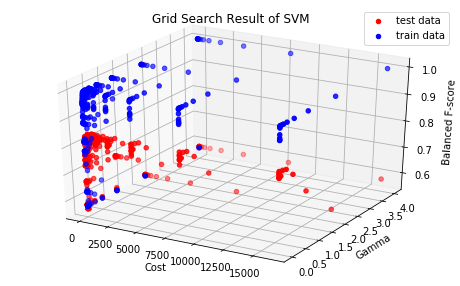

In [66]:
X_axis = svm_model.cv_results_['param_classifier__C'].data
Y_axis = svm_model.cv_results_['param_classifier__gamma'].data
test_axis = svm_model.cv_results_['mean_test_score']
train_axis= svm_model.cv_results_['mean_train_score']

plt.figure(figsize=(8,5))
ax = plt.axes(projection='3d')
ax.scatter(X_axis, Y_axis, test_axis, c='red', label='test data')
ax.scatter(X_axis, Y_axis, train_axis, c='blue', label='train data')

plt.title('Grid Search Result of SVM')
ax.set_xlabel('Cost')
ax.set_ylabel('Gamma')
ax.set_zlabel('Balanced F-score')
ax.legend();

## 4.3. Model Summary

In [35]:
print('Balanced F-score in:')
print('Test Data:',svm_model.cv_results_['mean_test_score'][svm_model.best_index_])
print('Train Data:',svm_model.cv_results_['mean_train_score'][svm_model.best_index_])
print('------------------------------------------------------------')
print('Parameters:')
print('Cost:',svm_model.cv_results_['param_classifier__C'][svm_model.best_index_])
print('Gamma:',svm_model.cv_results_['param_classifier__gamma'][svm_model.best_index_])

Balanced F-score in:
Test Data: 0.8458790156560818
Train Data: 0.9963923424407121
------------------------------------------------------------
Parameters:
Cost: 2048
Gamma: 0.00390625


## 4.3. Classification Result
Confusion matrix shows classification result.

In [52]:
CM = pd.crosstab(Y, svm_model.predict(X),rownames=['Actual'], colnames=['Predicted'])
print(CM)
print('--------------------------------')
print("SVM model accuarcy:",round(sum(Y == svm_model.predict(X))/Y.count(),4)*100,"%")

Predicted  acc  good  unacc  vgood
Actual                            
acc        384     0      0      0
good         0    69      0      0
unacc        3     2   1205      0
vgood        0     0      0     65
--------------------------------
SVM model accuarcy: 99.71 %


In [67]:
svm_model.predict(df)

array(['unacc', 'unacc', 'unacc', ..., 'unacc', 'good', 'vgood'],
      dtype=object)

## 5. Random Forest

Random forests are an ensemble learning method for classification that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes of the individual trees.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## 5.1  Turning Model Parameters with Grid Search

There are 6 parameters in random forest model.

n_estimators: number of trees in random forest.

max_features: number of features to consider when looking for the best split.

max_depth: maximum depth of the decision tree.

min_samples_split: minimum number of samples required to split an internal node.

min_samples_leaf: minimum number of samples required to be at a leaf node.

bootstrap: repeatedly sample data with replacement from the original training set in order to produce multiple separate training sets.

In [68]:
n_estimators = [2**i for i in range(1,6)]
max_features = ['auto', 'sqrt']
max_depth = [2**i for i in range(1,4)]
min_samples_split = [2**i for i in range(1,4)]
min_samples_leaf = [2**i for i in range(1,4)]
bootstrap = [True, False]

print('n_estimators:',n_estimators)
print('max_features:',max_features)
print('max_depth:',max_depth)
print('min_samples_split:',min_samples_split)
print('min_samples_leaf:',min_samples_leaf)
print('bootstrap:',bootstrap)

n_estimators: [2, 4, 8, 16, 32]
max_features: ['auto', 'sqrt']
max_depth: [2, 4, 8]
min_samples_split: [2, 4, 8]
min_samples_leaf: [2, 4, 8]
bootstrap: [True, False]


In [69]:
# Check if object exist
try:
    load('RF_pipeline.joblib') 
except FileNotFoundError:
    print("The model is not exist, now create & save model")
    
    from sklearn.ensemble import RandomForestClassifier
    
    rf_grid  = {'classifier__n_estimators': n_estimators,
               'classifier__max_features': max_features,
               'classifier__max_depth': max_depth,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf': min_samples_leaf,
               'classifier__bootstrap': bootstrap}
    
    rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])
    
    rf_model = GridSearchCV(rf_pipeline, 
                             rf_grid, cv=k_fold, scoring='f1_weighted',
                             return_train_score=True, n_jobs=-2)
    
    rf_model.fit(X,Y)
    # Save model in current folder 
    dump(rf_model, 'RF_pipeline.joblib')
else:
    rf_model = load('RF_pipeline.joblib')
    print("Reload existing model")

The model is not exist, now create & save model


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 4.2. Model Summary

In [70]:
print('Balanced F-score in:')
print('Test Data:',rf_model.cv_results_['mean_test_score'][rf_model.best_index_])
print('Train Data:',rf_model.cv_results_['mean_train_score'][rf_model.best_index_])
print('------------------------------------------------------------')
print('Parameters:')
print('n_estimators:',rf_model.cv_results_['param_classifier__n_estimators'][rf_model.best_index_])
print('max_features:',rf_model.cv_results_['param_classifier__max_features'][rf_model.best_index_])
print('max_depth:',rf_model.cv_results_['param_classifier__max_depth'][rf_model.best_index_])
print('min_samples_split:',rf_model.cv_results_['param_classifier__min_samples_split'][rf_model.best_index_])
print('min_samples_leaf:',rf_model.cv_results_['param_classifier__min_samples_leaf'][rf_model.best_index_])
print('bootstrap:',rf_model.cv_results_['param_classifier__bootstrap'][rf_model.best_index_])

Balanced F-score in:
Test Data: 0.780249149597914
Train Data: 0.9402656459302332
------------------------------------------------------------
Parameters:
n_estimators: 4
max_features: auto
max_depth: 8
min_samples_split: 2
min_samples_leaf: 2
bootstrap: True


## 5.3. Classification Result
Confusion matrix shows classification result.

In [86]:
CM = pd.crosstab(Y, rf_model.predict(X),rownames=['Actual'], colnames=['Predicted'])
print(CM)
print('--------------------------------')
print("Random Forest model accuarcy:",round(sum(Y == rf_model.predict(X))/Y.count(),4)*100,"%")

Predicted  acc  good  unacc  vgood
Actual                            
acc        359     2     22      1
good        21    46      0      2
unacc       25     0   1185      0
vgood        6     1      0     58
--------------------------------
Random Forest model accuarcy: 95.37 %


## 5.4. Feature Important in Random Forest

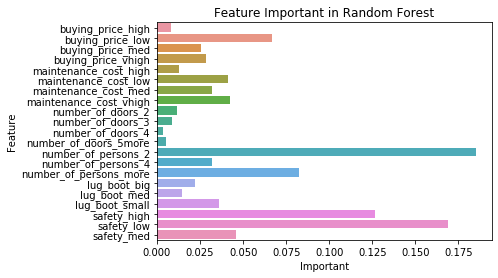

In [85]:
sns.barplot(y=encoded_feature_names,x=rf_model.best_estimator_.named_steps["classifier"].feature_importances_)

plt.title('Feature Important in Random Forest')
plt.xlabel('Important')
plt.ylabel('Feature');